In [0]:
import os
import pydot
import pandas as pd
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MaxAbsScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import f_regression
import xgboost as xgb
import matplotlib.pyplot as plt

In [0]:
def compute_f(X_trans, y, feature_names):
  F, p = f_regression(X_trans, y)
  F_test = pd.DataFrame(zip(feature_names, F, p), 
                    columns = ['feature', 'F-score', 'p-value']).sort_values('F-score', ascending = False)
  return F_test

def fit_model(X, y):
  categorical = X.dtypes == object
  preprocess = make_column_transformer(
  (make_pipeline(SimpleImputer(missing_values=np.nan, strategy='median')), ~categorical),
  (OneHotEncoder(handle_unknown='ignore'), categorical)) 

  X_trans = preprocess.fit_transform(X)

  feature_names = pd.get_dummies(X).columns

  F_test = compute_f(X_trans, y, feature_names)
  
  baseline = LinearRegression(normalize=True)
  bst_linear = xgb.XGBRegressor(n_estimators=500, max_depth = 20, booster='gblinear')
  bst_dive = xgb.XGBRegressor(n_estimators=500, max_depth = 3)
  
  X_trans = pd.DataFrame(columns=feature_names, data=X_trans)

  baseline.fit(X_trans, y)
  bst_linear.fit(X_trans, y)
  bst_dive.fit(X_trans, y)
  # print(rg.score(X_trans, y))
  return X_trans, F_test, baseline, bst_linear, bst_dive

def plot_imp(store_name, model, feature_names, base=True, division='Total Sales', if_show=True):
  
  coef = model.coef_

  coef_idx = np.argsort(coef)[::-1]

  colors=['red'if c > 0 else 'blue' for c in np.sort(-coef)]

  _ = plt.figure(figsize=(12, 8))
  _ = plt.bar([feature_names[i] for i in coef_idx], height=np.sort(coef)[::-1], color=colors)
  _ = plt.xlabel('Features')
  _ = plt.ylabel('Coefficients')
  if base:
    _ = plt.title('Coefficients for Baseline Linear Regression Model\n' +
                  division + '\n' +
                  store_name)
    filename = 'baseline_result.png'
  else:
    _ = plt.title('Features for XGB Regression Model\n' +
                  division + '\n' +
                  store_name)
    filename = 'xgb_result.png'

  _ = plt.xticks(rotation=90)
  plt.tight_layout()
  path = store_name + ' ' + division + ' Fundamental Model Analysis'
  plt.savefig(path + '/' + filename)
  if if_show:
    plt.show()

def fundamental_sales_analysis(store_name, events, sales, is_annual=False, division='Total Sales', if_show=True):
  
  events_base = events.drop(columns=['title', 'description', 'labels', 
                                     'venue_name', 'longitude', 'latitude', 
                                     'local_rank', 'aviation_rank'])
  
  df = pd.merge(events_base, sales[['sales_cleaned', 'date']], on='date')

  df = df.dropna()

  if is_annual == True:
    df = df[df.is_annual == 1]

  X = df.drop(columns=['sales_cleaned', 'date'])
  y = df['sales_cleaned']

  path = store_name + ' ' + division + ' Fundamental Model Analysis'
  if not os.path.exists(path):
    os.mkdir(path)
  
  # model fitting
  X_trans, F_test, baseline, bst_linear, bst_dive = fit_model(X, y)
  
  # Feature Screening
  if if_show:
    print(F_test[F_test['p-value'] <= 0.1])
  F_test.to_csv(os.path.join(path, 'F_test.csv'))

  # Model Analysis
  plot_imp(store_name, baseline, X_trans.columns, division, if_show=if_show)
  plot_imp(store_name, bst_linear, X_trans.columns, base=False, division=division, if_show=if_show)

  _ = xgb.plot_importance(bst_dive, max_num_features=5)
  plt.savefig(path + '/XGB_Top_5_Feature_Importances.png')
  tree = xgb.to_graphviz(bst_dive)
  tree.save(path + '/tree')
  (graph,) = pydot.graph_from_dot_file(path + '/tree')
  graph.write_png(path + '/features_tree.png')

def fundamental_divisions_analysis(store_name, events, divisions, is_annual=False):
  
  men = divisions['men']
  women = divisions['women']
  acc = divisions['accessory']

  fundamental_sales_analysis(store_name, events, men, is_annual, 'Men Sales', if_show=False)
  fundamental_sales_analysis(store_name, events, women, is_annual, 'Women Sales', if_show=False)
  fundamental_sales_analysis(store_name, events, acc, is_annual, 'Accessory Sales', if_show=False)


In [0]:
# Sample Data Preperation
events = pd.read_csv("/content/drive/My Drive/Events cleaned data/events_ORLANDO FOA.csv")
sales = pd.read_csv("/content/drive/My Drive/Sales Traffic cleaned data/Division_Cleaned/Cleaned/1211_Orlando_FOA_men_cleaned.csv")
men = pd.read_csv('/content/drive/My Drive/Sales Traffic cleaned data/Division_Cleaned/Cleaned/1211_Orlando_FOA_men_cleaned.csv')
women = pd.read_csv('/content/drive/My Drive/Sales Traffic cleaned data/Division_Cleaned/Cleaned/1211_Orlando_FOA_women_cleaned.csv')
acc = pd.read_csv('/content/drive/My Drive/Sales Traffic cleaned data/Division_Cleaned/Cleaned/1211_Orlando_FOA_accessory_cleaned.csv')

events.date = pd.to_datetime(events.date, format='%Y-%m-%d')
sales.date = pd.to_datetime(sales.date, format='%Y-%m-%d')
men.date = pd.to_datetime(men.date, format='%Y-%m-%d')
women.date = pd.to_datetime(women.date, format='%Y-%m-%d')
acc.date = pd.to_datetime(acc.date, format='%Y-%m-%d')

divisions = {
    'men': men,
    'women': women,
    'accessory': acc
}

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[00:27:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:27:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
               feature   F-score   p-value
18   category_politics  3.307275  0.068988
26   venue_type_indoor  3.157658  0.075586
27  venue_type_outdoor  3.157658  0.075586


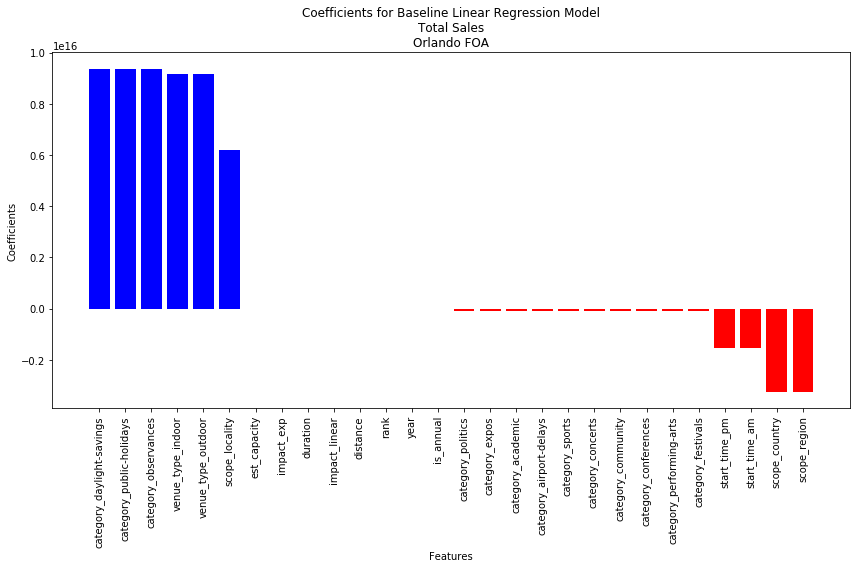

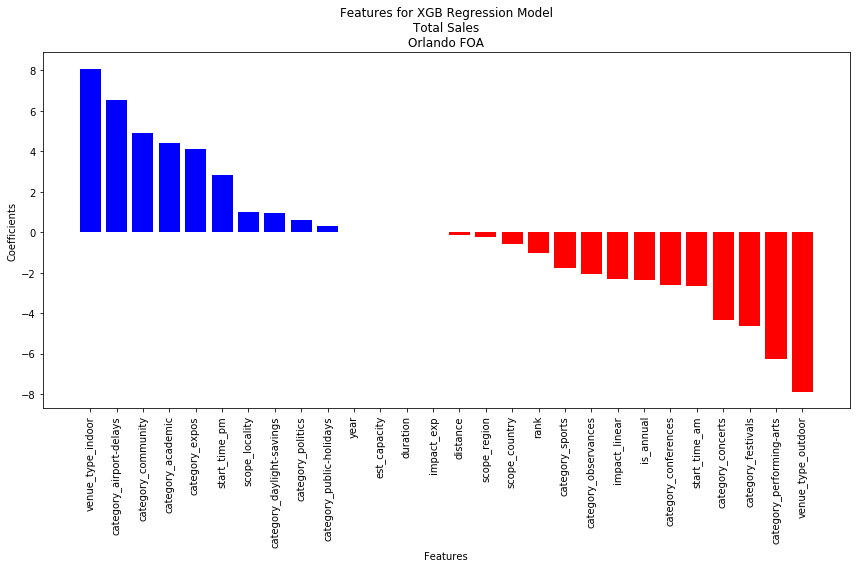

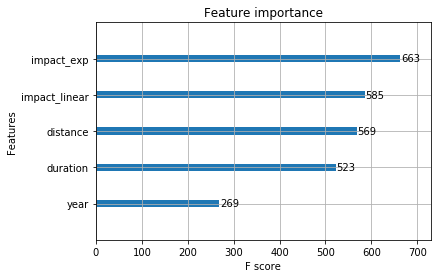

In [12]:
fundamental_sales_analysis('Orlando FOA', events, sales)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[00:29:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:29:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[00:29:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:29:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[00:29:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:29:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


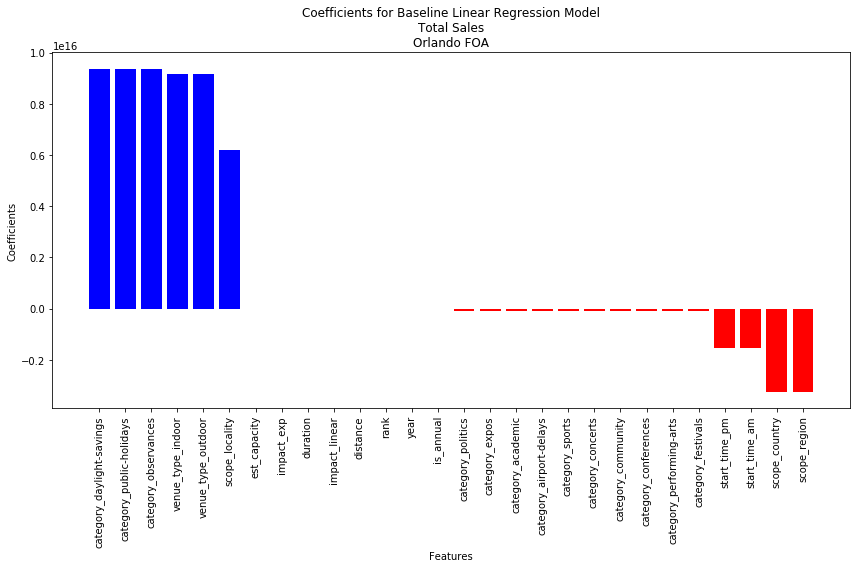

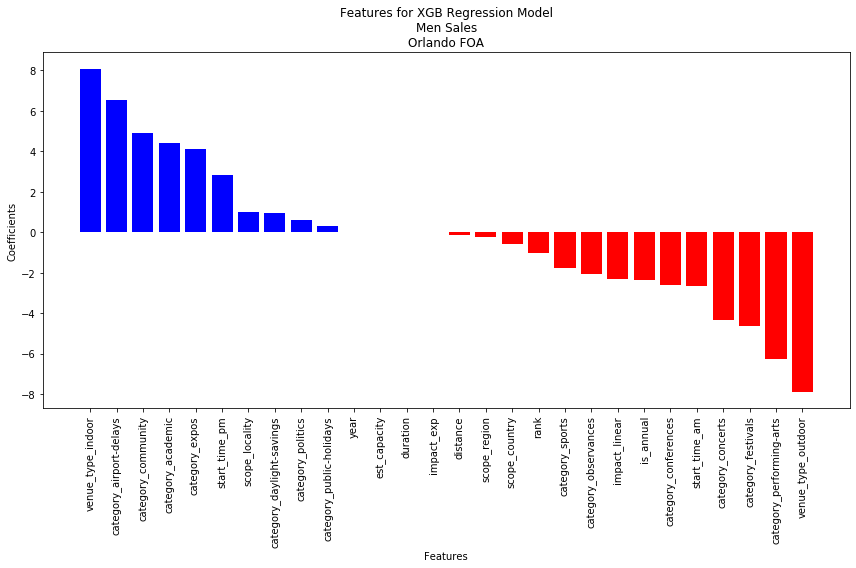

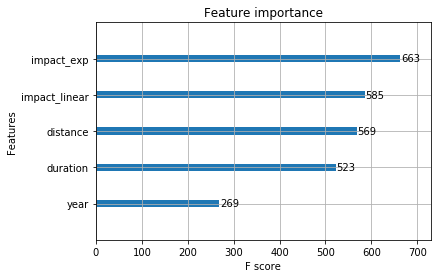

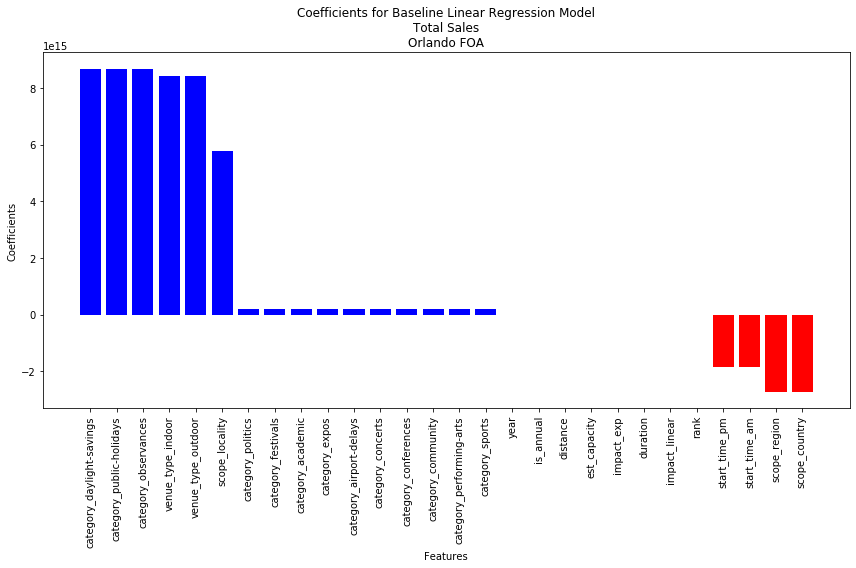

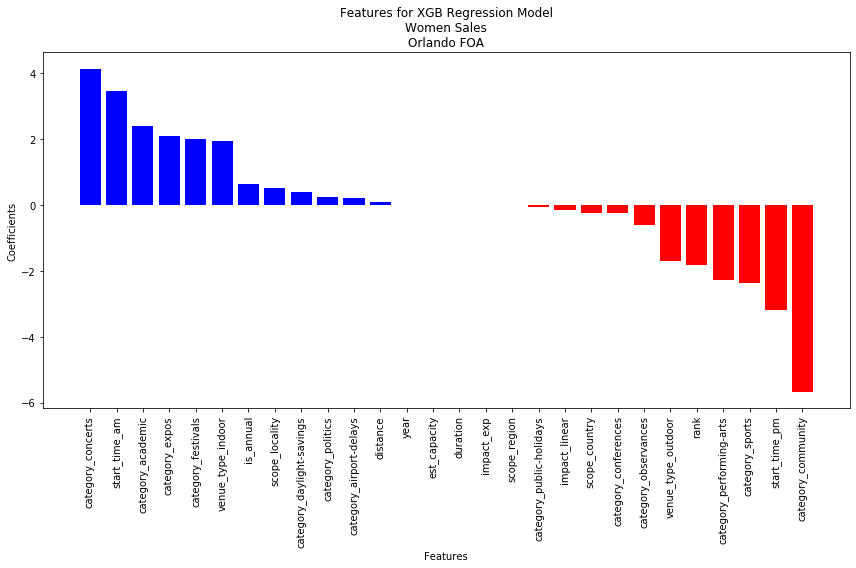

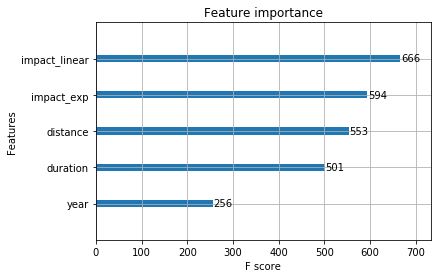

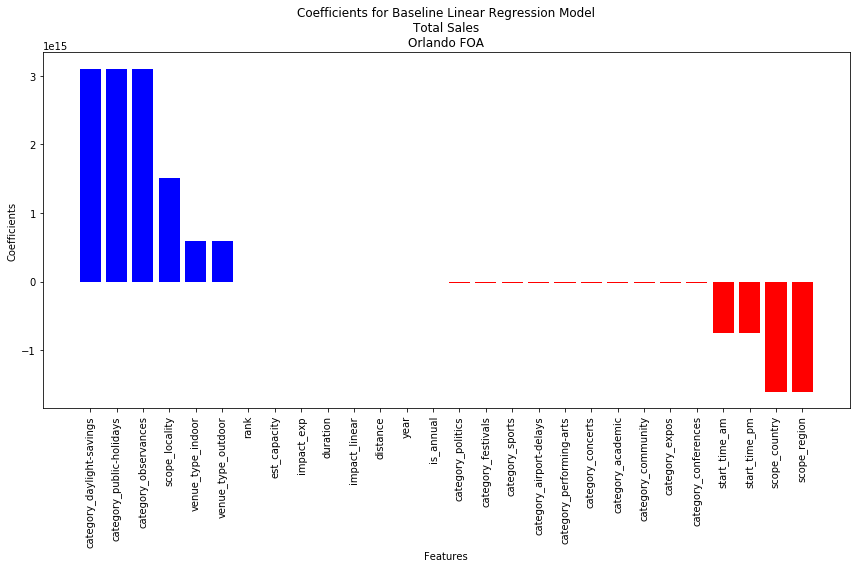

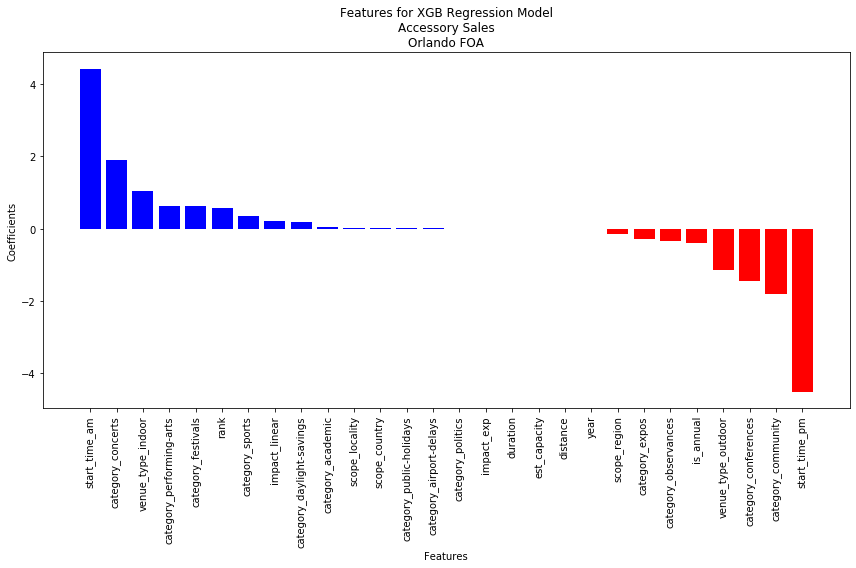

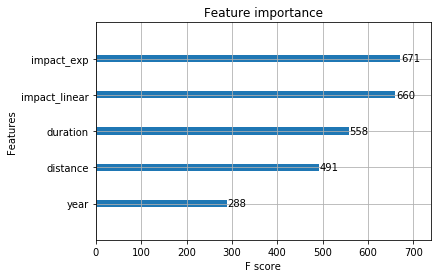

In [13]:
fundamental_divisions_analysis('Orlando FOA', events, divisions)